# Assignment 4
 - a) We will be working with the **AFHQ (Animal Faces-HQ)** dataset: https://github.com/clovaai/stargan-v2
    - Approx 15.000 images of animal faces (cat, dog, tiger, ...)
    - Downsample the images to 64x64
 - b) Write **Convolutional** Variational Autoencoder (ConvVAE)
      - Use Conv. layers for encoder and Transposed-Conv. layers for decoder.
      - You are only allowed to use linear layers for estimating the mean and standard deviation. Everything else should be convolutional.
 - c) Investigate the importance of the KL-divergence weight. For this purpose, train multiple models (at least 4) using different weighting values and investigate how this value affects the generation performance.
 - d) Generate new images by sampling latent vectors, investigate latent space and visualize some interpolations.
 - e) Compare the models from b) and c)
     - Qualitative comparison. Which images look better?
     - Quantitative comparison between models using the Fréchet Inception Distance: https://arxiv.org/abs/1706.08500
     - Log generated images and losses into the Tensorboard/W&B
     
     
**Extra Point:**
 - Extend your ConvVAE for Image generation conditioned on a given class. The AFHQ dataset has 3 classes: 'cat', 'dog', and 'wildlife'
 - Train your Conditional-ConvVAE
 - Show that you can generate images conditioned on a label
 - Tutorial: https://ijdykeman.github.io/ml/2016/12/21/cvae.html

In [1]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from utils import *
# from cvae import CVAE

from torch.utils.tensorboard import SummaryWriter

/home/user/soltania1/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/user/soltania1/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-05-31 16:30:16.191220: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-31 16:30:16.924967: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
configs = {   
    "model_name" : "CVAE",
    "exp" : "2",  
    "latent_dim" : 256,
    "batch_size" : 64,
    "num_epochs" : 50,
    "lr" : 5e-4,
    "scheduler" : "ReduceLROnPlateau",
    "use_scheduler" : True,
    "lambda_kld" : 1e-3,
    }

In [4]:
dataset_root = './data/AFHQ/'

transform = transforms.Compose([transforms.Resize((64,64)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5]*3 , [0.5]*3)])

BS = configs["batch_size"]

train_dataset = datasets.ImageFolder(root= dataset_root+'train', transform= transform )
test_dataset = datasets.ImageFolder(root= dataset_root+'test', transform= transform )

# print(train_dataset.classes)  
print(train_dataset.class_to_idx)  

train_loader = DataLoader(dataset= train_dataset, 
                          batch_size= BS, 
                          shuffle= True, 
                          drop_last= True )

test_loader = DataLoader(dataset= test_dataset, 
                          batch_size= BS, 
                          shuffle= False, 
                          drop_last= True )

{'cat': 0, 'dog': 1, 'wild': 2}


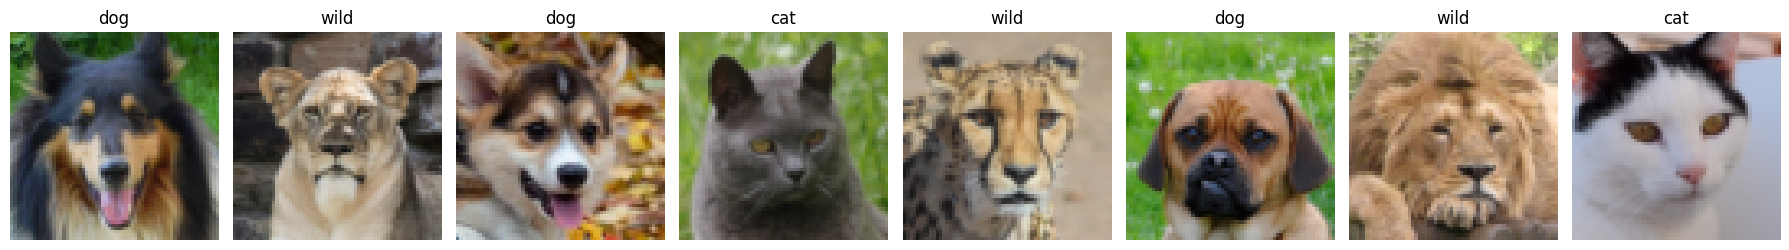

In [5]:
imgs, labels = next(iter(train_loader))
fig, ax = plt.subplots(1, 8)
fig.set_size_inches(18, 5)
for i in range(8):
    img_np = imgs[i].permute(1, 2, 0).numpy()
    # Denormalize the image
    img_np = (img_np * 0.5 + 0.5).clip(0, 1)
    ax[i].imshow(img_np)
    ax[i].axis("off")
    ax[i].set_title(f"{train_dataset.classes[labels[i]]}")
plt.tight_layout()
plt.show()

In [ ]:
imgs.shape

torch.Size([64, 3, 64, 64])

In [7]:

# class ConvVAE(nn.Module):
    """
    Implementation of a fully connect autoencoder for 
    denoising  MNIST images
    """
    
    def __init__(self, in_size=(3, 64, 64), sizes=[3, 32, 64, 128], act=nn.GELU(), dropout = 0.2):
        """ Model initlaizer """
        # assert np.prod(in_size) == sizes[0]
        super().__init__()
        
        self.in_size = in_size
        self.sizes = sizes 
        self.activation = act
        self.dropout = dropout
        
        # self.encoder = self._make_encoder()
 
        # Compute encoder output size dynamically and based on encoder architecture
        # encoder_output_size= self._compute_encoder_output_size()
        # enc_flat_out_size, self.enc_out_h, self.enc_out_w = encoder_output_size

        # self.enc_flat_out_size= self._compute_encoder_output_size()
        # enc_flat_out_size, self.enc_out_h, self.enc_out_w = encoder_output_size

        # self.decoder = self._make_decoder()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )
        # self.decoder = nn.Sequential(
        #                 nn.ConvTranspose2d(256, 128, kernel_size=4, stride=1, padding=0),  # 1×1 → 4×4
        #                 nn.BatchNorm2d(128),
        #                 nn.ReLU(),

        #                 nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 4×4 → 8×8
        #                 nn.BatchNorm2d(64),
        #                 nn.ReLU(),

        #                 nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 8×8 → 16×16
        #                 nn.BatchNorm2d(32),
        #                 nn.ReLU(),

        #                 nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # 16×16 → 32×32
        #                 nn.BatchNorm2d(16),
        #                 nn.ReLU(),

        #                 nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),   # 32×32 → 64×64
        #                 nn.Sigmoid()
        #             )

        self.decoder = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),
            nn.Sigmoid()
        )

        # Creating the linear layers based on encoder output size
        self.fc_mu = nn.Sequential( nn.Linear(self.enc_flat_out_size, self.sizes[-1]),
                                    self.activation,
                                    nn.Dropout(self.dropout * 2))
        self.fc_sigma = nn.Sequential (nn.Linear(self.enc_flat_out_size, self.sizes[-1]),
                                       self.activation,
                                       nn.Dropout(self.dropout * 2))

    def _compute_encoder_output_size(self): 
        """Compute the flattened size of the encoder's output."""
        # Create a dummy input tensor to check the encoder's output shape
        with torch.no_grad():
            dummy_input = torch.zeros(1, *self.in_size)  # Shape: (1, C, H, W)
            encoder_output = self.encoder(dummy_input)
            print("encoder output shape: ", encoder_output.shape)
            enc_flat_out_size = encoder_output.view(1, -1).size(1) 
            print("encoder flatetened shape: ",enc_flat_out_size)
            self.enc_out_h = encoder_output.size(2)
            self.enc_out_w = encoder_output.size(3)

            return enc_flat_out_size
        
    # def conv_block(self, 
    #                in_ch, 
    #                out_ch,
    #                stride,
    #                kernel_size,
    #                padding,
    #                downsample : bool, 
    #                encoder = None, 
    #                decoder = None):

    #     layers = []


    #     # stride = 2 if (downsample and encoder) else 1
    #     # kernel_size = 3 if encoder else 4

    #     if encoder:
    #         conv_type = nn.Conv2d
    #     elif decoder:
    #         conv_type = nn.ConvTranspose2d
    #         # layers.append(nn.UpsamplingNearest2d(scale_factor=2))

    #     layers.append(conv_type(in_ch, 
    #                             out_ch, 
    #                             kernel_size= kernel_size,
    #                             stride= stride, 
    #                             padding= padding,
    #                             bias=False )) # Since we're using BatchNorm, avoiding redundant bias learning
    #     layers.append(nn.BatchNorm2d(out_ch)) # batch norm  adds a learnable bias to the model
    #     layers.append( self.activation )
    #     if downsample and encoder:
    #         layers.append(nn.Dropout(self.dropout))

    #     return nn.Sequential(*layers)


    # def _make_encoder(self):
    #     """ Defining encoder """
    #     encoder_blocks = []
        
    #     for i in range(len(self.sizes)-2):
    #         in_ch = self.sizes[i]
    #         out_ch = self.sizes[i+1]
    #         # for n in range(2):
    #             # stride  = 1 if n ==0 else 2
    #         stride = 2
    #         encoder_block =self.conv_block(in_ch,
    #                                         out_ch, 
    #                                         stride= stride,
    #                                         downsample= True, #if stride == 2 else True,
    #                                         kernel_size= 3,
    #                                         padding= 1,
    #                                         encoder= True)
    #         in_ch = out_ch
    #         encoder_blocks.append(encoder_block)
           
    #     encoder = nn.Sequential(*encoder_blocks)
    #     return encoder
    
    # def _make_decoder(self):
    #     """ Defining decoder """
    #     decoder_blocks = []
    #     kernel_size = 4 

    #     in_ch = self.sizes[-1]
    #     for i in range(1, len(self.sizes)):
    #         stride = 1 if i == 1 else 2
    #         padding = 0 if i == 1 else 1
    #         out_ch = self.sizes[-i-1] #if not i == len(self.sizes)-1 else 3
    #         decoder_block = self.conv_block( in_ch,
    #                                         out_ch,
    #                                         stride= stride,
    #                                         kernel_size= kernel_size,
    #                                         padding= padding,
    #                                         downsample= True if stride == 2 else False,
    #                                         decoder= True)
    #         in_ch = out_ch
    #         decoder_blocks.append(decoder_block)
    #         # layers.append( nn.ConvTranspose2d(in_channels= self.sizes[-i],
    #         #                                   out_channels= 3 if i == len(self.sizes)-1 else self.sizes[-i-1], 
    #         #                                   kernel_size= 3,
    #         #                                   stride= 1, 
    #         #                                   padding= 1))
    #         # layers.append( self.activation )
    #     decoder_blocks.append(self.conv_block(32,
    #                                         16,
    #                                         stride= stride,
    #                                         kernel_size= kernel_size,
    #                                         padding= padding,
    #                                         downsample= True if stride == 2 else False,
    #                                         decoder= True))  
    #     decoder_blocks.append(self.conv_block(16,
    #                                         3,
    #                                         stride= stride,
    #                                         kernel_size= kernel_size,
    #                                         padding= padding,
    #                                         downsample= True if stride == 2 else False,
    #                                         decoder= True))        
    #     # replacing last act and dropout with sigmoid
    #     decoder_blocks = decoder_blocks[:-1] + [nn.Sigmoid()]
    #     decoder = nn.Sequential(*decoder_blocks)
    #     return decoder

    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)  # we can also predict the std directly, but this works best
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    
    def forward(self, x):
        """ Forward pass """
        # encoding 
        x_enc = self.encoder(x)
        print(f"Encoder output shape: {x_enc.shape}")
    
    # Debug flattened shape
        encoded_flat = x_enc.view(x_enc.size(0), -1)
        print(f"Flattened shape: {encoded_flat.shape}")

        mu = self.fc_mu(encoded_flat)
        log_var = self.fc_sigma(encoded_flat)

        # reparametrization trick
        z = self.reparameterize(mu, log_var) # z.shape: (64, 256)
        z = z.view(*z.size(), 1, 1) # z.shape: (64, 256, 1, 1)

        # decoding
        x_hat_flat = self.decoder(z)
        x_hat = x_hat_flat.view(-1, *self.in_size)
        
        return x_hat, (z, mu, log_var)

In [10]:
class CVAE(nn.Module):
    def __init__(self, in_channels=3, latent_dim=256):
        super(CVAE, self).__init__()
        
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            # Input: (3, 64, 64)
            nn.Conv2d(in_channels, 16, kernel_size=4, stride=2, padding=1),  # (16, 32, 32)
            nn.BatchNorm2d(16),
            nn.GELU(),
            
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),  # (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.GELU(),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.GELU(),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.GELU(),
            
            nn.Flatten()  # 128 * 4 * 4 = 2048
        )
        
        # Fully connected layers for mu and sigma
        self.fc_mu = nn.Linear(2048, latent_dim)
        self.fc_sigma = nn.Linear(2048, latent_dim)
        
        '''
        Also called projection layer, projects latent vector to correct size for decoder
        maps the latent variable into a space compatible with the decoder input
        '''
        self.decoder_input = nn.Sequential(
            nn.Linear(latent_dim, 2048),
            nn.GELU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            # Input: (128, 4, 4)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.GELU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.GELU(),
            
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # (16, 32, 32)
            nn.BatchNorm2d(16),
            nn.GELU(),
            
            nn.ConvTranspose2d(16, in_channels, kernel_size=4, stride=2, padding=1),  # (3, 64, 64)
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, log_var):
        """Reparameterization trick"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        # Encode
        x_encoded = self.encoder(x)
        
        # Get mu and log_var
        mu = self.fc_mu(x_encoded)
        log_var = self.fc_sigma(x_encoded)
        
        # Reparameterization trick
        z = self.reparameterize(mu, log_var)
        
        # Project and reshape for decoder
        z = self.decoder_input(z)
        z = z.view(-1, 128, 4, 4)
        x_hat = self.decoder(z)
        
        return x_hat, (z, mu, log_var) 
    

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CVAE(latent_dim=configs["latent_dim"]).to(device)


In [9]:
# model

In [10]:
count_model_params(model.encoder)

691104

In [12]:
# count_model_params(model.decoder)

In [13]:
count_model_params(model.fc_mu) + count_model_params(model.fc_sigma) 

8915456

In [14]:
count_model_params(model)

14758467

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=7, factor=0.5, verbose=True)

/home/user/soltania1/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [16]:
model_name = configs["model_name"]+configs["exp"]
savepath = f"imgs/{model_name}"
os.makedirs(savepath,exist_ok=True)


TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", model_name)
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)
shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)

In [17]:
def vae_loss_function(recons, target, mu, log_var, lambda_kld=configs["lambda_kld"]):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
    recons_loss = F.mse_loss(recons, target)
    kld = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)  # closed-form solution of KLD in Gaussian
    loss = recons_loss + lambda_kld * kld

    return loss, (recons_loss, kld)

In [ ]:
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=model, 
        optimizer=optimizer,
        scheduler=scheduler if configs["use_scheduler"] else None, 
        criterion=vae_loss_function,
        train_loader=train_loader, 
        valid_loader=test_loader, 
        num_epochs=configs["num_epochs"], 
        savepath=savepath,
        writer=writer
    )

In [ ]:
save_model(model, model_name, optimizer, epoch = configs["num_epochs"], stats = None )

In [ ]:
img_vs_recons(model, test_loader, device)

In [29]:
def compute_encoder_output_size(batch_size, input_shape):
    """
    Compute the un/flattened output size of the encoder given an input shape.
    """
    with torch.no_grad():

        enc_input = torch.zeros(batch_size, *input_shape).to(device)  # (BS, 3, 64, 64)
        output = model.encoder(enc_input)
        flattened_size = output.view(1, -1).shape[1]
    return output.shape, flattened_size


In [30]:
compute_encoder_output_size(BS, (3, 64, 64))

(torch.Size([64, 2048]), 131072)

## Inference 

In [ ]:
if not os.path.exists(f"imgs/inference/{model_name}"):
    os.makedirs(f"imgs/inference/{model_name}")

latent_dim = configs["latent_dim"]

enc_output_shape, _ = compute_encoder_output_size(BS, (3, 64, 64))

with torch.no_grad():
    for i in range(5):
        z = torch.randn(BS, latent_dim).to(device)

        z = model.decoder_input(z)
        z = z.view(-1, *enc_output_shape)

        recons = model.decoder(z)
        recons = recons.view(BS, 3, 64, 64)
        save_image(recons, f"imgs/inference/{model_name}/inference_{i}.png")

plt.figure(figsize=(8*2, 4*2))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(recons[i, 0].cpu(),imgs[i, 0] * 0.5 + 0.5)
    plt.axis("off")
plt.tight_layout()
plt.show()



### Investigating the importance of the KL-divergence

In Variational Autoencoders (VAEs), the loss is:
**Total Loss = Reconstruction Loss + λ * KLD**

Reconstruction Loss (e.g. MSE): Measures how well the VAE reconstructs the input.

KLD: Encourages the latent space distribution to be close to a standard normal (regularization).

There is a the trade-off between:

1. Accurate reconstructions (low MSE)
2. Structured latent space (low KLD)

If:

lambda_kld is too low → poor latent structure (overfit to data, bad generative quality)

lambda_kld is too high → poor reconstructions (model ignores input to match prior)

lambda_kld_values = [0.0, 1e-4, 1e-3, 1e-2]

| λ (KLD weight) | Effect                                                      |
| -------------- | ----------------------------------------------------------- |
| `0.0`          | Pure autoencoder (no latent regularization)                 |
| `1e-4`         | Very weak KLD → good reconstructions, weak latent structure |
| `1e-3`         | Balanced trade-off                                          |
| `1e-2`         | Strong KLD → worse recons, better sampling and latent space |

